# Weighted resampling for data exchange

1. generate two populations of some samples: sample1 and sample2
1. calculate weights for them based on omega and (1-omega)
1. exchange!
    1. calculate weights for resampling by the original weights
    1. resampling!
1. estimate the distribution (discrete)
1. compare the two distributions?


In [60]:
import random
import math
import matplotlib.pyplot as plt
import statistics

In [61]:
f_optimize_sigma = False
sigma_def = 5

# generate two populations of some samples: sample1 and sample2

In [62]:
rng = [0, 100]
dlt = 0.05
n_samples = 300
def genSamples(center):
    samples = []
    for i in range(n_samples):
        #samples.append(random.uniform(rng[0] + (rng[1]-rng[0])*0.1, rng[1] - (rng[1]-rng[0])*0.1))
        if i % 5 == 0:
            samples.append(rng[0] + (rng[1]-rng[0])*center)
        else:
            samples.append(random.uniform(rng[0], rng[1]))
        #samples.append(random.uniform(rng[0], rng[1]))
        #samples.append(random.gauss((rng[0]+rng[1])/2.0, (rng[1]-rng[0])/2.0 * 0.1))
    return samples
samples1 = genSamples(0.4)
samples2 = genSamples(0.6)
print("sample1:")
print("max: " + str(max(samples1)))
print("min: " + str(min(samples1)))
print("sample2:")
print("max: " + str(max(samples2)))
print("min: " + str(min(samples2)))

sample1:
max: 99.8577806302921
min: 0.22246898160125372
sample2:
max: 99.99785238691035
min: 1.9945688201505885


# estimate the distributions (discrete)

In [63]:
sigma_opt = lambda s: statistics.variance(s) * math.pow(4.0/3.0/len(s), 1.0/5.0)
k = lambda x1, x2, sigma=sigma_def: math.exp(-(x1 - x2)**2/sigma/sigma)
x = rng[0]
N = int((rng[1]-rng[0])/dlt+1)
x_axis = [rng[0] + i * dlt for i in range(N)]

def estPDF(samples):
    x = rng[0]
    p = [0] * N
    sigma = sigma_opt(samples) if f_optimize_sigma else sigma_def
    for i in range(N):
        x = rng[0] + i * dlt
        for s in samples:
            p[i] += k(x, s, sigma)
    sum_p = sum(p) * dlt
    for i in range(len(p)):
        p[i] /= sum_p
    return p
def showPDF(p, title, ylim=None):
    plt.scatter(x_axis, p)
    plt.ylabel(title)
    if ylim != None:
        plt.ylim(0, ylim)
    plt.show()
    print('sum: ' + str(sum(p)*dlt))

In [64]:
p1 = estPDF(samples1)
p2 = estPDF(samples2)

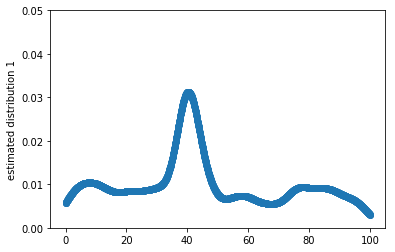

sum: 0.999999999999997


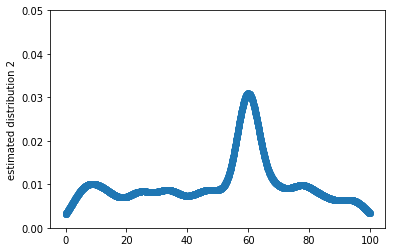

sum: 0.9999999999999987


In [65]:
showPDF(p1, 'estimated distribution 1', 0.05)
showPDF(p2, 'estimated distribution 2', 0.05)

# calculate weights for them based on omega and (1-omega)

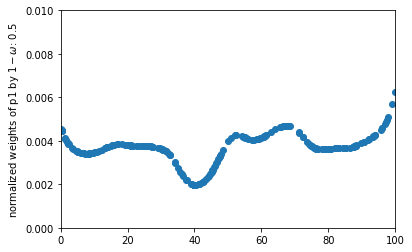

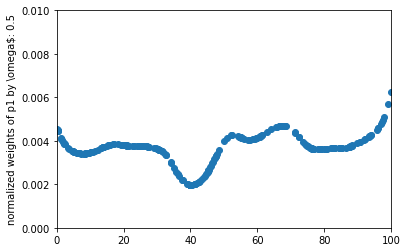

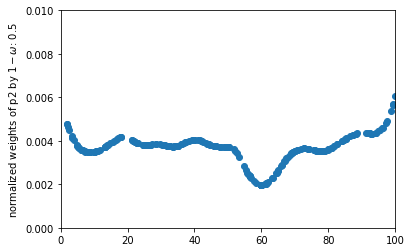

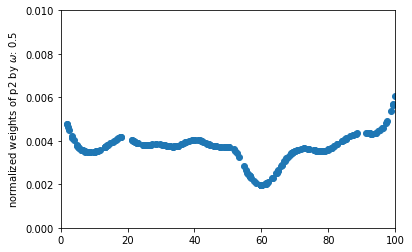

In [66]:
omega = 0.5
def genWeights(samples, omg):
    weights = [0] * n_samples
    sigma = sigma_opt(samples) if f_optimize_sigma else sigma_def
    for i in range(n_samples):
        for j in range(n_samples):
            weights[i] += k(samples[i], samples[j], sigma)
        weights[i] = math.pow(weights[i], omg - 1)
    return weights
w1 = genWeights(samples1, 1 - omega) # 1 - omega
w1c = genWeights(samples1, omega) # omega
w2 = genWeights(samples2, 1 - omega) # 1 - omega
w2c = genWeights(samples2, omega) # omega
def showW(samples, weights, title, ylim = None):
    sum_weight = sum(weights)
    w = list(weights)
    for i in range(n_samples):
        w[i] /= sum_weight
    plt.scatter(samples, w)
    plt.ylabel(title)
    if not ylim == None:
        plt.ylim(0, ylim)
    plt.xlim(rng[0], rng[1])
    plt.show()
showW(samples1, w1, 'normalized weights of p1 by $1 - \omega$: ' + str(1 - omega), 0.01)
showW(samples1, w1c, 'normalized weights of p1 by \omega$: ' + str(omega), 0.01)
showW(samples2, w2, 'normalized weights of p2 by $1 - \omega$: ' + str(1 - omega), 0.01)
showW(samples2, w2c, 'normalized weights of p2 by $\omega$: ' + str(omega), 0.01)

# exchange!
1. calculate weights for resampling by the original weights
1. resampling!

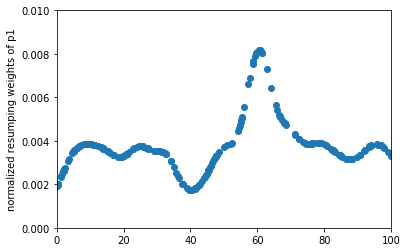

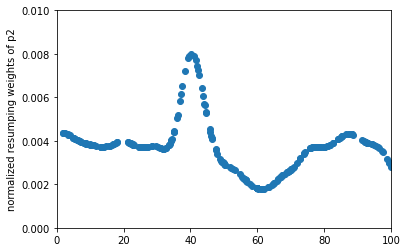

In [67]:
def genWresump(samplesA, samplesB, wA, wBc):
    w_resump = [0] * len(samplesA)
    for i in range(len(samplesA)):
        for j in range(len(samplesB)):
            w_resump[i] += k(samplesA[i], samplesB[j]) * wBc[j]
        w_resump[i] *= wA[i]
    return w_resump
w1_resump = genWresump(samples1, samples2, w1, w2c)
w2_resump = genWresump(samples2, samples1, w2, w1c)
showW(samples1, w1_resump, 'normalized resumping weights of p1', 0.01)
showW(samples2, w2_resump, 'normalized resumping weights of p2', 0.01)

In [68]:
def resumple(samples, weights):
    next_samples = [0] * n_samples
    sum_weight = sum(weights)
    print('sum of weights: ' + str(sum_weight))
    for i in range(n_samples):
        r = random.uniform(0.0, sum_weight)
        temp = 0
        for j in range(n_samples):
            temp += weights[j]
            if r <= temp or j == n_samples - 1:
                next_samples[i] = samples[j]
                break
    return next_samples
new_samples1 = resumple(samples1, w1_resump)
new_samples2 = resumple(samples2, w2_resump)

sum of weights: 268.32960376378713
sum of weights: 268.329603763787


# estimate the distribution (discrete)

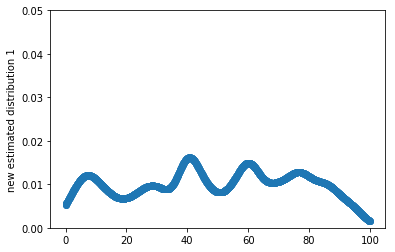

sum: 1.000000000000001


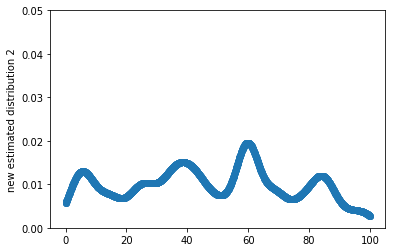

sum: 1.0


In [69]:
new_p1 = estPDF(new_samples1)
new_p2 = estPDF(new_samples2)
showPDF(new_p1, 'new estimated distribution 1', 0.05)
showPDF(new_p2, 'new estimated distribution 2', 0.05)

# compare the two distributions?
1. create two distributions based on p1 and p2
1. then?

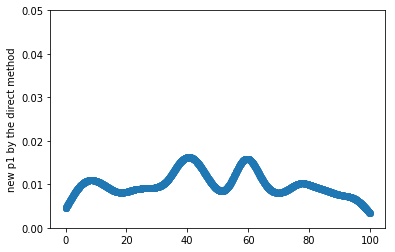

sum: 1.0


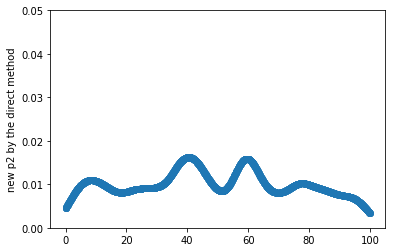

sum: 1.0


In [70]:
def multiP(pa, pb, omg1, omg2):
    new_p = [0] * len(pa)
    for i in range(len(new_p)):
        new_p[i] = math.pow(pa[i], omg1) * math.pow(pb[i], omg2)
    sum_new_p = sum(new_p) * dlt
    for i in range(len(new_p)):
        new_p[i] /= sum_new_p
    return new_p
new_p1_direct = multiP(p1, p2, 1-omega, omega)
new_p2_direct = multiP(p2, p1, 1-omega, omega)
showPDF(new_p1_direct, 'new p1 by the direct method', 0.05)
showPDF(new_p2_direct, 'new p2 by the direct method', 0.05)

---
# what if $omega = 0$?


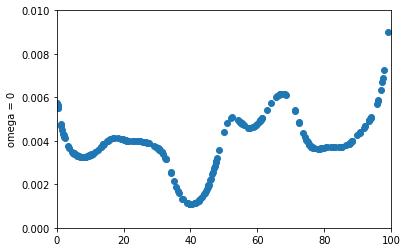

sum of weights: 11.340136914519066


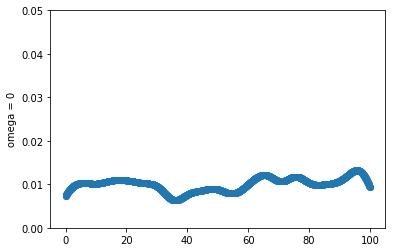

sum: 0.9999999999999981


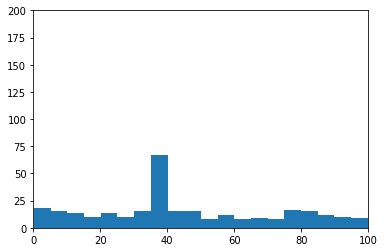

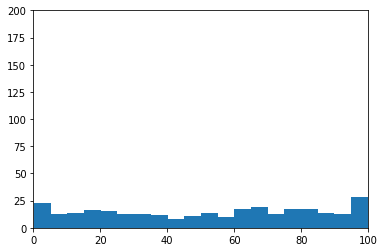

In [71]:
w = genWeights(samples1, 0)
showW(samples1, w, 'omega = 0', 0.01)
ns1 = resumple(samples1, w)
np1 = estPDF(ns1)
showPDF(np1, 'omega = 0', 0.05)
plt.ylim(0, 200)
plt.xlim(rng[0], rng[1])
plt.hist(samples1, bins=20)
plt.show()
plt.ylim(0, 200)
plt.xlim(rng[0], rng[1])
plt.hist(ns1, bins=20)
plt.show()